In [601]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

In [602]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return self.block(x) + x


In [603]:
class ResNet(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, out_channels=3, num_blocks=8):
        super(ResNet, self).__init__()

        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.residual_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.residual_blocks.append(ResidualBlock(hidden_channels))

        self.output_block = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels // 2, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(hidden_channels // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_channels // 2, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.input_block(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.output_block(x)
        return x


In [604]:
def show_images(images):
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [605]:
def show_minibatch_images(images):
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        image = image[0].detach().cpu().numpy()
        image = image.transpose(1, 2, 0)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [606]:
def get_pyramid(image, n_layers, show_images=True):
    image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image = image.unsqueeze(0)
    pyramid = [image]
    for _ in range(n_layers - 1):
        image = F.max_pool2d(image, kernel_size=2)
        pyramid.append(image)

    if show_images:
        show_minibatch_images(pyramid)

    return pyramid

In [607]:
def show_output(output):
    output = output[0].detach().cpu().numpy()
    output = output.transpose(1, 2, 0)
    plt.imshow(output)
    plt.axis('off')
    plt.show()

In [608]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [609]:
torch.manual_seed(97)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cuda


In [614]:
n_layers = 3
lr = [0.02, 0.01, 0.005]
epochs = [200, 200, 200]
color_guided = 0.5
fname = 'img.png'

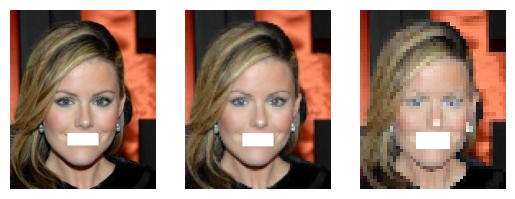

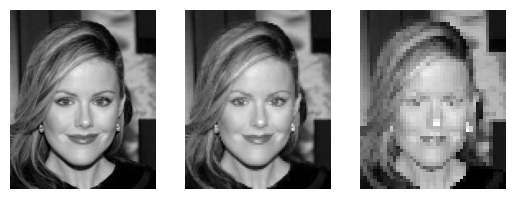

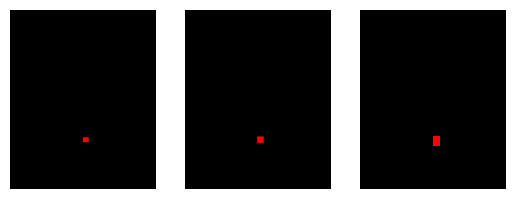

In [615]:
color_path = f'./color/{fname}'
mask_path = f'./mask/{fname}'
gray_path = f'./gray/{fname}'
guide_path = f'./guide/{fname}'

color = cv2.cvtColor(cv2.imread(color_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
gray = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)[:,:,None]
mask = cv2.imread(mask_path)
if color_guided:
    guide = cv2.cvtColor(cv2.imread(guide_path), cv2.COLOR_BGR2RGB)
else:
    guide = np.zeros_like(color)

color_pyramid = get_pyramid(color, n_layers)[::-1]
mask_pyramid = get_pyramid(mask, n_layers, show_images=False)[::-1]
gray_pyramid = get_pyramid(gray, n_layers)[::-1]
guide_pyramid = get_pyramid(guide, n_layers)[::-1]

Layer 0:   0%|          | 0/200 [00:00<?, ?it/s]

Layer 0: 100%|██████████| 200/200 [00:01<00:00, 119.87it/s]


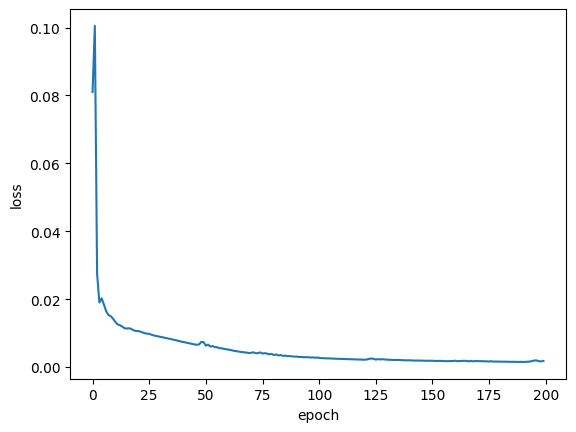

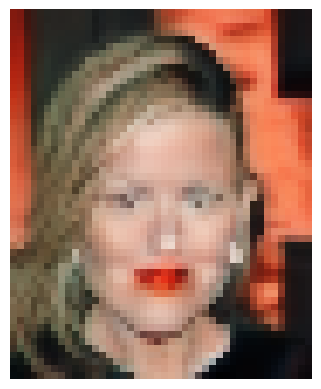

Layer 1: 100%|██████████| 200/200 [00:02<00:00, 73.20it/s]


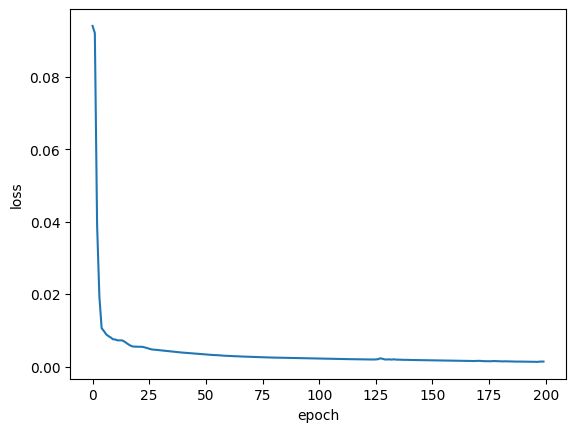

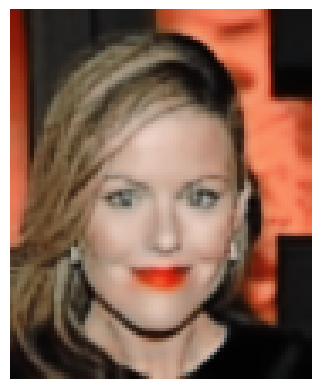

Layer 2: 100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


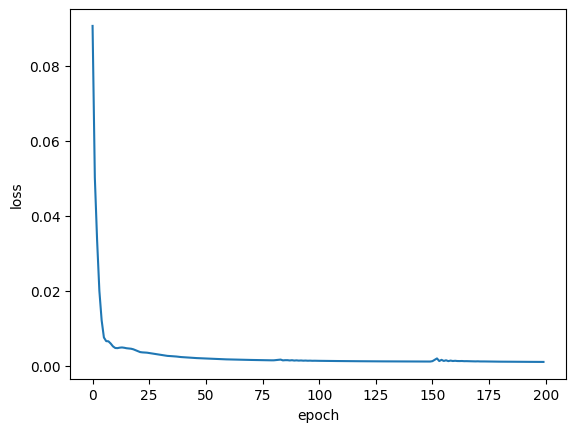

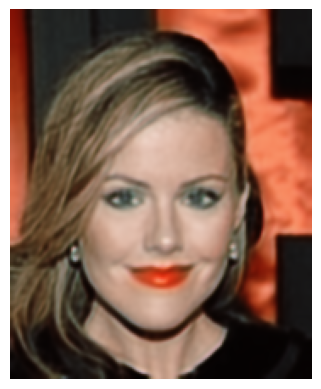

In [616]:
results = []
criterion = nn.MSELoss()
for i, (color, mask, gray, guide) in enumerate(zip(color_pyramid, mask_pyramid, gray_pyramid, guide_pyramid)):
    color = color.to(device)
    gray = gray.to(device)
    mask = 1.0 - mask.to(device)
    guide = guide.to(device)
    is_guided = torch.where(guide.sum(dim=1, keepdim=True) > 0, 1.0, 0.0)
    is_guided = torch.cat([is_guided, is_guided, is_guided], dim=1)

    if i == 0:
        input = gray
    else:
        output = output.squeeze().detach()
        output = transforms.Resize((gray.shape[2], gray.shape[3]))(output)
        output = output.unsqueeze(0)
        output = torch.clamp(output, min=0, max=1)
        input = torch.cat((gray, output), dim=1)

    target = color * mask + guide

    model = ResNet(in_channels=input.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr[i])
    losses = []
    for epoch in tqdm(range(epochs[i]), desc=f'Layer {i}'):
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output * mask, target) + \
            color_guided * criterion(output * is_guided, guide)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

    plot_losses(losses)
    show_minibatch_images([output])


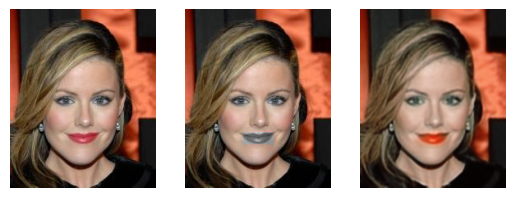

In [617]:
input = color_pyramid[-1] * (1.0 - mask_pyramid[-1]) + gray_pyramid[-1] * mask_pyramid[-1]
if os.path.isfile(f'./images/{fname}'):
    original = torch.from_numpy(cv2.cvtColor(cv2.imread(f'images/{fname}'), cv2.COLOR_BGR2RGB)).permute(2, 0, 1).float().unsqueeze(0) / 255.0
else:
    original = torch.from_numpy(np.ones_like(color_pyramid[-1]))
show_minibatch_images([original, input, output])